### Predicting Bitcoin Prices using Time Series Analysis
The goal of this project is to forecast the prices of Bitcoin. Several Python API including sklearn, Tensorflow and Facebook Prophet API are used to analyze the closing prices of Bitcoin ranging from April 2018 up until April 2020. The methodologies adopted include traditional statistical tests and procedures like the Dicky-Fuller test and ARIMA (AutoRegressive Integrated Moving Average), and Machine Learning approaches like XGBoost and Neural Network. 


In [24]:
!pip install chart-studio

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from plotly import tools
import chart_studio.plotly  as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv
/kaggle/input/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv


### Loading dataset

In [26]:
import datetime, pytz
#Function to convert time field from pure number into readable format
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [27]:
data = pd.read_csv('../input/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv', parse_dates=[0], date_parser=dateparse)

In [28]:
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)

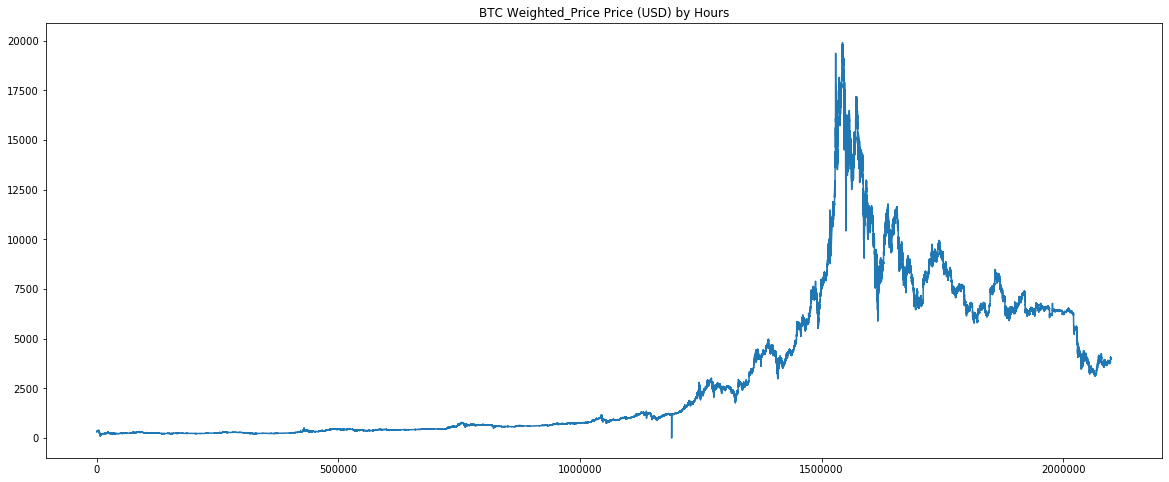

In [29]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Hours')
plt.plot(data.Weighted_Price, '-', label='By Hours')

In [30]:
### Convert data into monthly data for ARIMA model
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

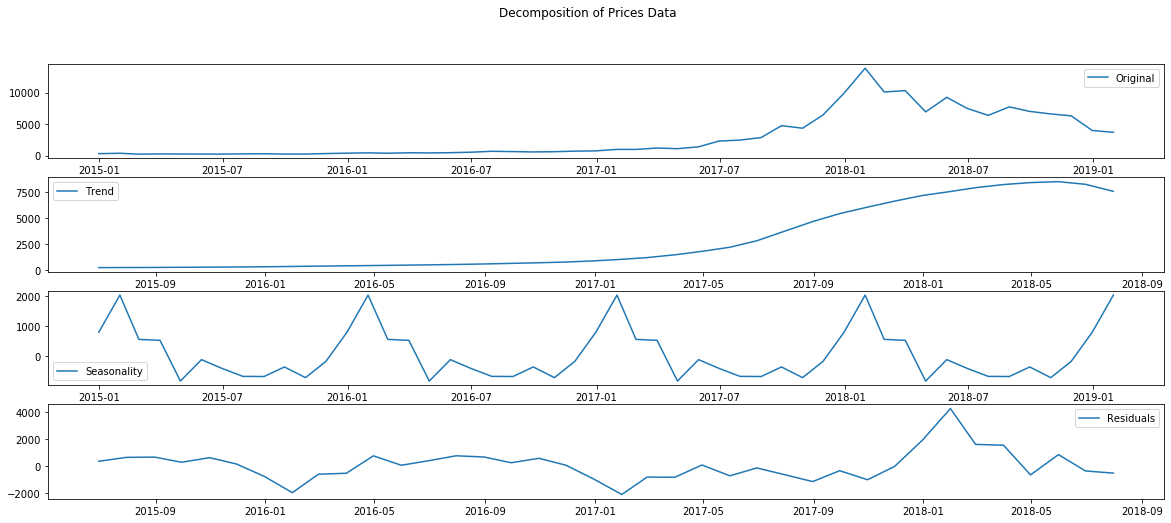

In [31]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
### Decomposition of the time series
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

### ARIMA Model Building

In [32]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.Weighted_Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [33]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
46  (2, 1, 2, 0)  191.168026
41  (2, 0, 2, 1)  197.851973
40  (2, 0, 2, 0)  198.432807
47  (2, 1, 2, 1)  202.368346
52  (2, 2, 2, 0)  205.171349
                                      SARIMAX Results                                      
Dep. Variable:                      Weighted_Price   No. Observations:                   50
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood                 -89.584
Date:                             Wed, 06 May 2020   AIC                            191.168
Time:                                     02:43:19   BIC                            193.555
Sample:                                 12-31-2014   HQIC                           189.663
                                      - 01-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

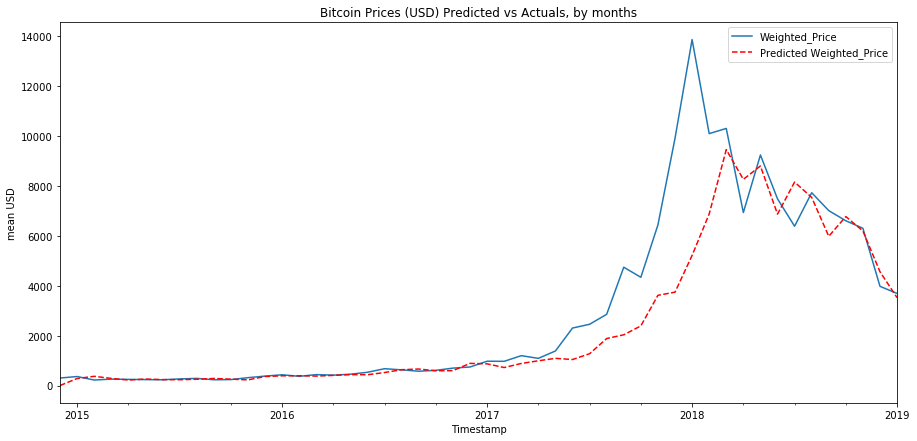

In [34]:
df_month2 = data[['Weighted_Price']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

## LSTM Neural Network

In [36]:
data = pd.read_csv('../input/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv', parse_dates=[0], date_parser=dateparse)
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)

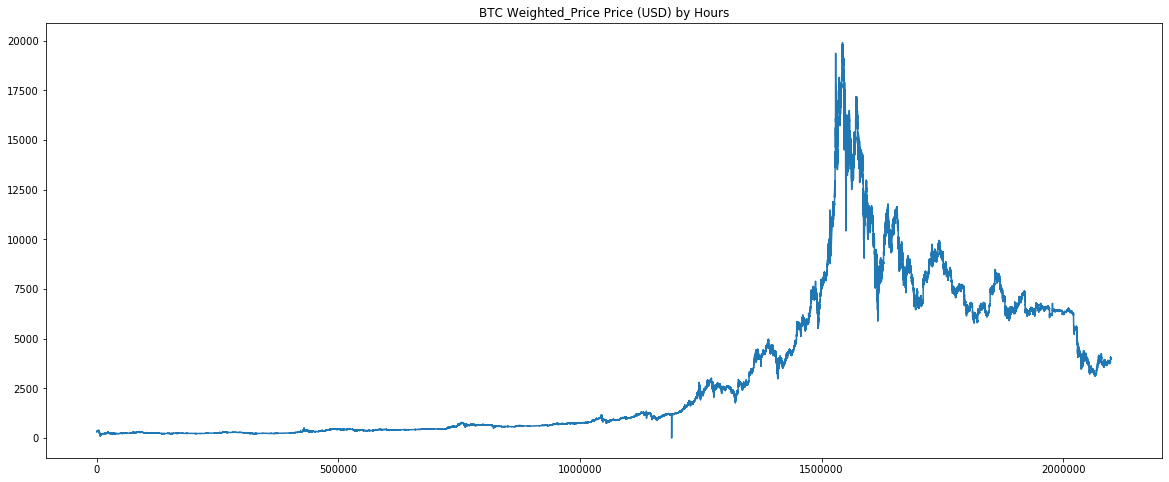

In [37]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Hours')
plt.plot(data.Weighted_Price, '-', label='By Hours')

In [38]:
len(data)

2099760

In [39]:
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
len(data)


35970

In [40]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:00:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
1,2014-12-01 06:00:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
2,2014-12-01 07:00:00,370.00,370.00,370.00,370.00,0.026556,9.825550,370.000000
3,2014-12-01 08:00:00,370.00,370.00,370.00,370.00,0.026556,9.825550,370.000000
4,2014-12-01 09:00:00,370.00,370.00,370.00,370.00,0.026556,9.825550,370.000000
...,...,...,...,...,...,...,...,...
35965,2019-01-07 18:00:00,4016.00,4016.00,4014.18,4014.18,0.837287,3361.638067,4014.917403
35966,2019-01-07 19:00:00,4015.55,4015.56,4015.55,4015.56,2.795896,11227.067232,4015.551976
35967,2019-01-07 20:00:00,4024.00,4025.00,4024.00,4025.00,10.042872,40413.837925,4024.131416
35968,2019-01-07 21:00:00,4006.73,4007.01,4006.72,4007.01,21.797277,87340.366252,4006.939254


In [41]:
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data

,Weighted_Price
Timestamp,
2014-12-01 05:00:00,300.000000
2014-12-01 06:00:00,300.000000
2014-12-01 07:00:00,370.000000
2014-12-01 08:00:00,370.000000
2014-12-01 09:00:00,370.000000
...,...
2019-01-07 18:00:00,4014.917403
2019-01-07 19:00:00,4015.551976
2019-01-07 20:00:00,4024.131416


In [42]:
# split data
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()


In [43]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
training_set

array([[ 300.       ],
       [ 300.       ],
       [ 370.       ],
       ...,
       [6155.7597129],
       [6144.8185706],
       [6148.1598727]])

In [ ]:
training_set

In [44]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

X_train.shape

(31243, 1)

In [45]:
X_train = np.reshape(X_train, (len(X_train), 1, 1)) ## make train set shape from (31243, 1) to (31243,1,1)
X_train.shape

(31243, 1, 1)

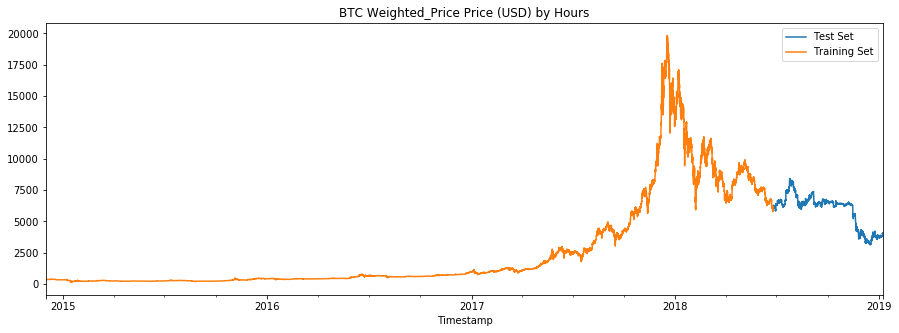

In [46]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [47]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [48]:
### Train model
model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=2)

Epoch 1/10
 - 4s - loss: 0.0375
Epoch 2/10
 - 2s - loss: 0.0117
Epoch 3/10
 - 2s - loss: 0.0062
Epoch 4/10
 - 2s - loss: 0.0044
Epoch 5/10
 - 2s - loss: 0.0034
Epoch 6/10
 - 2s - loss: 0.0027
Epoch 7/10
 - 3s - loss: 0.0022
Epoch 8/10
 - 2s - loss: 0.0019
Epoch 9/10
 - 2s - loss: 0.0016
Epoch 10/10
 - 2s - loss: 0.0014


In [49]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [50]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

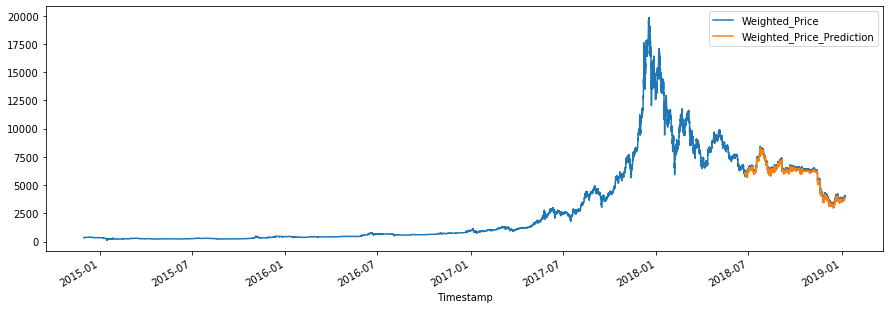

In [51]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [52]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

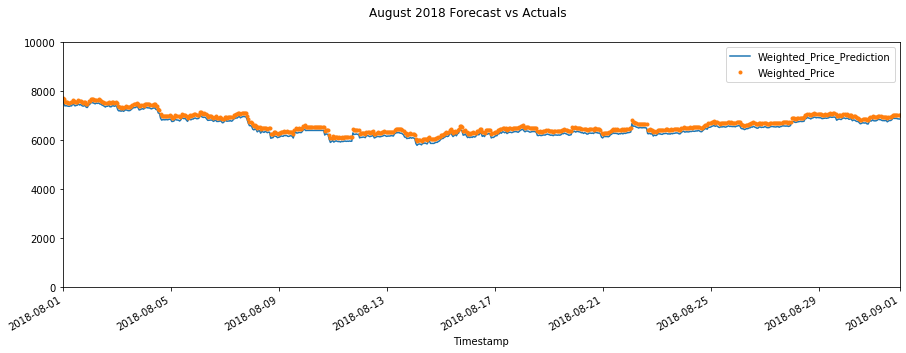

In [53]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

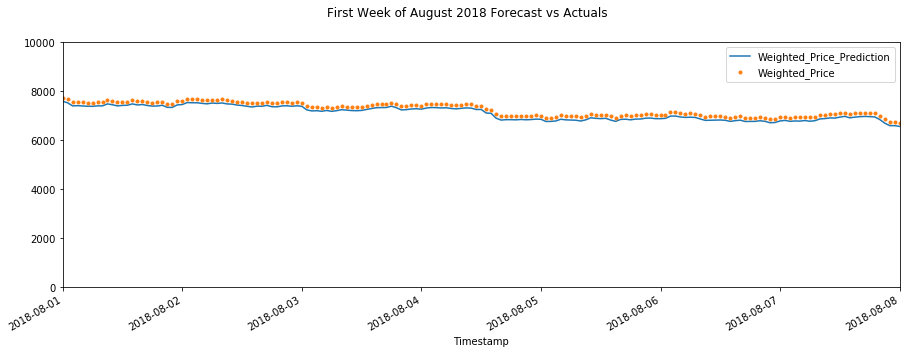

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

## XGBoost

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [56]:
data = pd.read_csv('../input/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv', parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

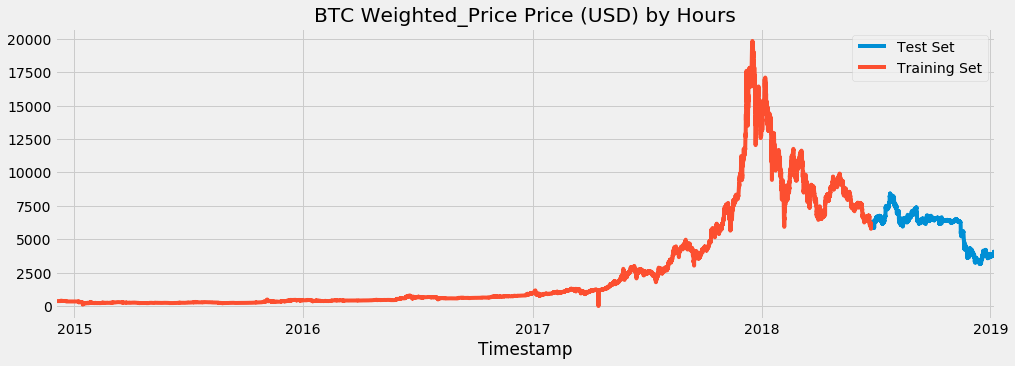

In [57]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [58]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [59]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

In [60]:
X_train.head(5)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Timestamp,,,,,,,,
2014-12-01 05:00:00,5,0,4,12,2014,335,1,49
2014-12-01 06:00:00,6,0,4,12,2014,335,1,49
2014-12-01 07:00:00,7,0,4,12,2014,335,1,49
2014-12-01 08:00:00,8,0,4,12,2014,335,1,49
2014-12-01 09:00:00,9,0,4,12,2014,335,1,49


In [61]:
y_train

Timestamp
2014-12-01 05:00:00     300.000000
2014-12-01 06:00:00     370.000000
2014-12-01 07:00:00     370.000000
2014-12-01 08:00:00     370.000000
2014-12-01 09:00:00     370.000000
                          ...     
2018-06-24 20:00:00    6168.280442
2018-06-24 21:00:00    6182.251095
2018-06-24 22:00:00    6155.759713
2018-06-24 23:00:00    6144.818571
2018-06-25 00:00:00    6148.159873
Name: Weighted_Price, Length: 31244, dtype: float64

In [62]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[02:44:32] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [63]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [64]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp','Weighted_Price','lstm']]

In [65]:
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost']]

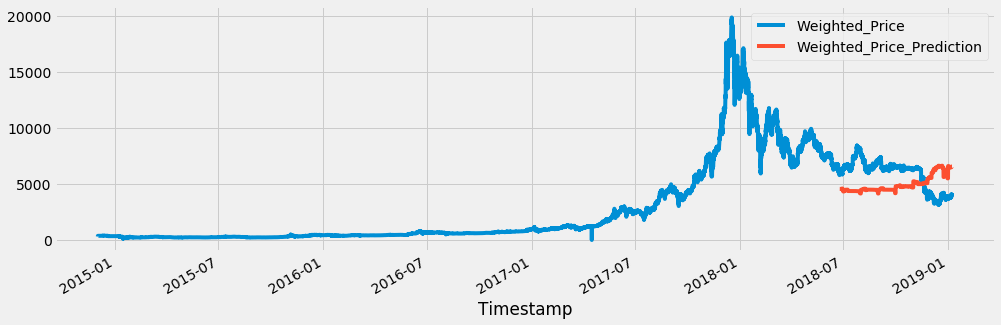

In [66]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [67]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

4787540.573536799

In [68]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

2066.604033209612

### Facebook Prophet API for Time Series

In [69]:
data_train = data_train.reset_index().rename(columns={'Timestamp':'ds', 'Weighted_Price':'y'})

In [70]:
data_train.head()

,ds,y,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2014-12-01 05:00:00,300.0,2014-12-01 05:00:00,5,0,4,12,2014,335,1,49
1,2014-12-01 06:00:00,370.0,2014-12-01 06:00:00,6,0,4,12,2014,335,1,49
2,2014-12-01 07:00:00,370.0,2014-12-01 07:00:00,7,0,4,12,2014,335,1,49
3,2014-12-01 08:00:00,370.0,2014-12-01 08:00:00,8,0,4,12,2014,335,1,49
4,2014-12-01 09:00:00,370.0,2014-12-01 09:00:00,9,0,4,12,2014,335,1,49


In [ ]:
model = Prophet()
model.fit(data_train)

In [ ]:
# Predict on test set with model
data_test_fcst = model.predict(df=data_test.reset_index().rename(columns={'Timestamp':'ds'}))

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)

In [ ]:
# Plot the components
fig = model.plot_components(data_test_fcst)

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

In [ ]:
#for comparision of predictions
data_fcst = data_test_fcst
data_fcst = data_fcst.rename(columns={'ds': 'Timestamp'})
data_all = pd.concat([data_fcst, data_train], sort=False)
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'yhat': 'prophet'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost','prophet']]

In [ ]:
final_data

In [ ]:
data_test

In [ ]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])